# GDYNIA

### Scraping out information from home pages

In [1]:
# vars
url = 'https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/pomorskie/gdynia/gdynia/gdynia'
url_n = 'https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/pomorskie/gdynia/gdynia/gdynia?page='
city = 'gdynia'

In [2]:
import os

# prepering directories
path = os.getcwd()
# subfolders
input_dir = os.path.join(path, 'inputs')
output_dir = os.path.join(path, 'outputs')

In [3]:
# selenium 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# BeautifulSoup
from bs4 import BeautifulSoup

import datetime
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


Bad key "text.kerning_factor" on line 4 in
C:\Users\Ukasz\Anaconda3\envs\geopandas\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# chrome driver location
PATH = os.path.join(path, 'inputs','chromedriver.exe' )

# chrom driver configuration
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
#options.add_argument('--headless') # without opening browser

driver = webdriver.Chrome(PATH, options=options)

wait = WebDriverWait(driver, 10)

In [5]:
# get number of pages

# open website using webdriver
driver.get(url)
print(f"Opens website: {url}")

# accepting terms and conditions
# step One - pokaz cele
element = wait.until(EC.element_to_be_clickable((By.ID, 'onetrust-pc-btn-handler')))
element.click()
# step two -  confirming preferences and closing the modal window
element = wait.until(EC.element_to_be_clickable((By.XPATH, "//*[contains(text(), 'Potwierdzenie moich wyborów')]")))
element.click()

# step - get number of the paginations
## using SOUP
soup = BeautifulSoup(driver.page_source, 'html.parser')
# save homepage to the file & soup
date = datetime.datetime.now().strftime("%Y%m%d") # current date
    
# finds nav with paginations 
# scrapped HTML code can be displayed and pretty printed in Notepad++ using the plugin XML tools
target = soup.find('nav', attrs={'aria-label':'Nawigacja po paginacji'})
date = datetime.datetime.now().strftime("%Y%m%d") # current date
with open(os.path.join(path, 'outputs', 'nav_pagination' + date + '.html'), "w", encoding='utf-8') as file:
    file.write(str(target))
    
# selects all hyperlinks from the nav section
hrefs = target.find_all("a")
# get the hyperlink with the highest number which represents number of pages with adds for the given city
pagination_last = 1
for a in hrefs:
    try:
        num = int(a.get_text())
        pagination_last =  num if pagination_last < num else pagination_last
    except:
        pass
print(f'Number of pages: {pagination_last}')

Opens website: https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/pomorskie/gdynia/gdynia/gdynia
Number of pages: 46


In [6]:
all_df = pd.DataFrame()

In [7]:
def scrap_page(url):
    '''
    - returns a soup section of a given page containing adds
    '''
    driver.get(url)
    time.sleep(2) # waits n seconds
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    return soup.find('div', attrs={'data-cy':'search.listing.organic'})
    
def has_article(tag):
    '''
    - info about adds is kept in <li> that contain <artcicle> tag
    '''
    return tag.name == 'li' and tag.find('article') is not None

def get_adds(data):
    '''
    - info about adds is kept in <li> that contain <article> tag
    '''
    return data.find_all(has_article)

def soup_to_dataframe(data):
    '''
    - gets soup and returns dataframe
    '''
    adds = []
    for add in data:
        artcile = add.find('article')
        # gets any tags with the attribute 'title'
        titles = artcile.find_all(lambda tag: tag is not None and tag.has_attr("title"))
        price = price_meter = rooms = area = more = None

        info = add.find_all('span')
        for e in info:
            e = e.text
            if '\xa0zł' in e and 'zł/m²' not in e:
                price = e
            if 'zł/m²' in e:
                price_meter = e
            if [element for element in ['pokoje','pokoi','pokój'] if(element in e)]:
                rooms = e
            if 'm²' in e and 'zł/m²' not in e:
                area = e
        more = info[-1].text

        adds.append({
            'free_text': titles[0]['title'],
            'address': titles[1]['title'],
            'price': price,
            'price_meter': price_meter,
            'rooms': rooms,
            'area': area,
            'more':more,
            'add_link': add.select_one('a')['href']
        })
    # Creates DataFrame.
    df = pd.DataFrame(adds)
    
    return df


for n in range(pagination_last):
    n = n + 1
    print(str(n), end='...')
    data = scrap_page(url_n + str(n))
    data = get_adds(data)
    df = soup_to_dataframe(data)
    df.to_csv(os.path.join(output_dir, f'{city}_page_{str(n)}.csv'), encoding='utf-8', index=False)
    # merges datframes
    all_df = pd.concat([all_df, df])
    all_df = all_df.reset_index(drop=True)
    date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

all_df.to_csv(os.path.join(output_dir, f'{city}_page_all_pages_{date}.csv'), encoding='utf-8', index=False)
    
    

1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...

### BASIC STATS

In [8]:
# OPENS FILE EXPLORER OF THE GIVEN DIRECTORY
import subprocess
import os
path = os.path.join(os.getcwd(), 'outputs')
subprocess.Popen(f'explorer "{path}"')

In [22]:
data = pd.read_csv(os.path.join(os.getcwd(), 'outputs', 'gdynia_page_all_pages_20240108103159.csv'))

In [23]:
data.shape

(1626, 8)

In [24]:
data.head(2)

,free_text,address,price,price_meter,rooms,area,more,add_link
0,Nowy apartament Gdynia Orłowo - 2 pokoje,"Mieszkanie na sprzedaż: ul. Klonowa, Orłowo, G...",769 000 zł,17 089 zł/m²,2 pokoje,45 m²,Biuro nieruchomości,/pl/oferta/nowy-apartament-gdynia-orlowo-2-pok...
1,Klimatyczna Nieruchomość Doskonała Pod Inwesty...,Mieszkanie na sprzedaż: Wzgórze Św. Maksymilia...,685 000 zł,11 396 zł/m²,3 pokoje,"60,11 m²",Biuro nieruchomości,/pl/oferta/klimatyczna-nieruchomosc-doskonala-...


#### Cleaning the 'price' column

In [25]:
data = data[data['price'] != 'Art-Dom Grażyna Kozłowska']

In [26]:
data['price'] = data['price'].str.replace(u'\xa0', u' ')
data['price'] = data['price'].str.replace(' ', '', regex=True)
data['price'] = data['price'].str.replace('zł', '', regex=True)
data['price'] = data['price'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['price'].notna()]
data['price'] = pd.to_numeric(data['price'])

#### Cleaning the 'price_meter' column

In [27]:
data['price_meter'] = data['price_meter'].str.replace(u'\xa0', u' ')
data['price_meter'] = data['price_meter'].str.replace(' ', '', regex=True)
data['price_meter'] = data['price_meter'].str.replace('zł/m²', '', regex=True)
data['price_meter'] = data['price_meter'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['price_meter'].notna()]
data['price_meter'] = pd.to_numeric(data['price_meter'])

#### Cleaning the 'area' column

In [28]:
data['area'] = data['area'].str.replace(u'\xa0', u' ')
data['area'] = data['area'].str.replace(' ', '', regex=True)
data['area'] = data['area'].str.replace('m²', '', regex=True)
data['area'] = data['area'].str.replace(',', '.', regex=True)
# drop nan
data = data[data['area'].notna()]
data['area'] = pd.to_numeric(data['area'])

In [29]:
# Getting rid of outliers PRICE
print("99.5% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99.5)))
data = data[(data['price'] <= np.percentile(data['price'], 99.5)) & (data['price'] > 0)]

99.5% properties have a price lower than  4850745.00


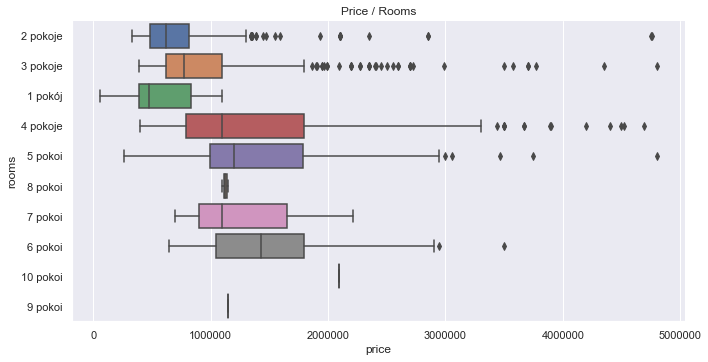

In [30]:

sns.catplot(data=data, x="price", y="rooms", kind="box", height=5, aspect=2)
plt.title('Price / Rooms')
plt.show()

In [31]:
# Getting rid of outliers AREA
print("99.5% properties have a area lower than {0: .2f}".format(np.percentile(data['area'], 99.5)))
data = data[(data['area'] <= np.percentile(data['area'], 99.5)) & (data['area'] > 0)]

99.5% properties have a area lower than  196.00


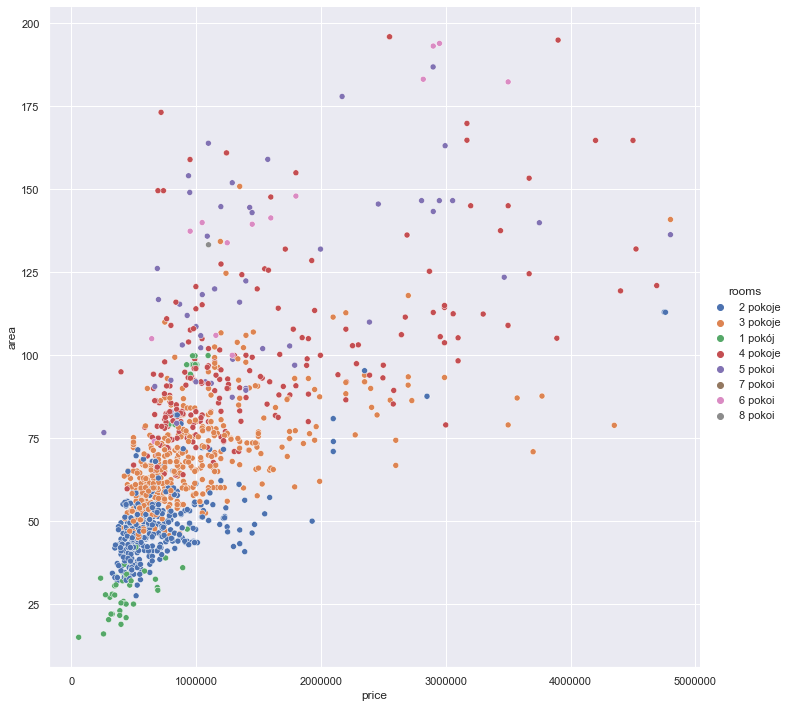

In [32]:
sns.relplot(data=data, x="price", y="area", hue="rooms", height=10)

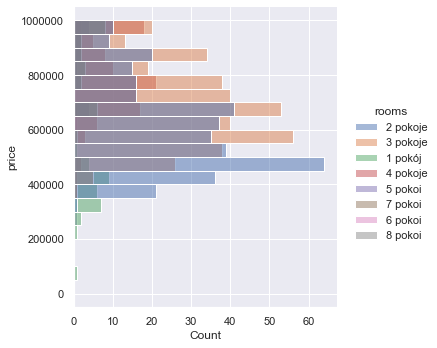

In [33]:
sns.displot(data, y="price", bins=list(range(0,1050000, 50000 )), hue='rooms')


In [34]:
data.describe().astype(int)

,price,price_meter,area
count,1337,1337,1337
mean,998437,14187,69
std,693896,6111,27
min,60000,3416,15
25%,594000,10258,50
50%,772000,12340,62
75%,1120000,16430,81
max,4800000,55147,196


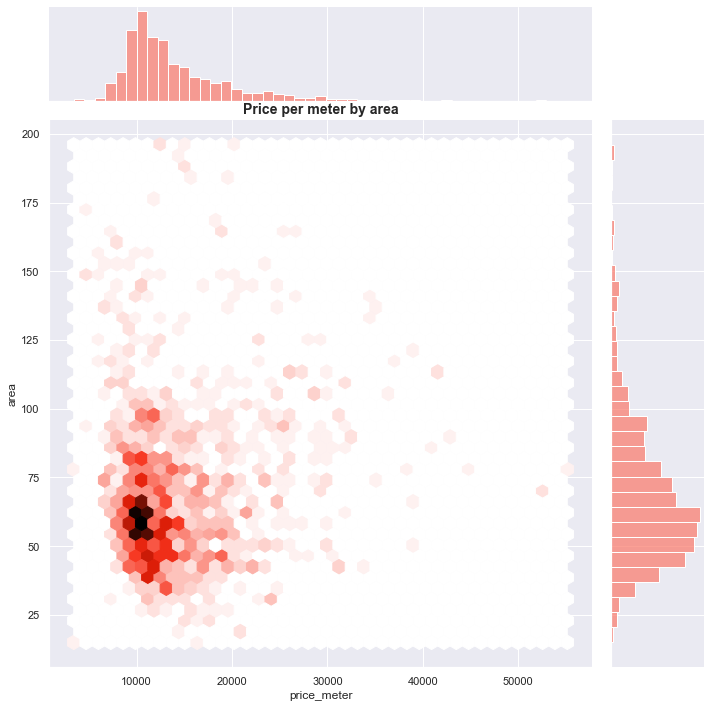

In [35]:
sns.jointplot(data=data, x="price_meter", y="area", kind="hex", color='#fa8072', height = 10)
plt.title('Price per meter by area', fontsize=14, fontweight='bold');

In [36]:
data['rooms_number'] = data['rooms'].str.extract('(\d+)').astype(int)

In [37]:
data.describe().astype(int)

,price,price_meter,area,rooms_number
count,1337,1337,1337,1337
mean,998437,14187,69,2
std,693896,6111,27,0
min,60000,3416,15,1
25%,594000,10258,50,2
50%,772000,12340,62,3
75%,1120000,16430,81,3
max,4800000,55147,196,8


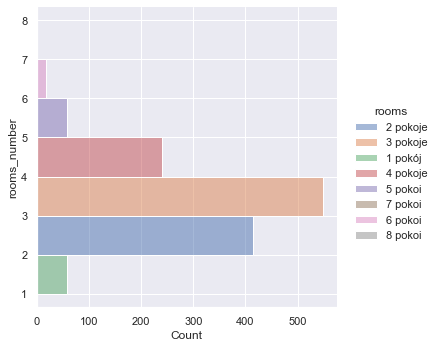

In [38]:
sns.displot(data, y="rooms_number", bins=list(range(1,max(data['rooms_number'] + 1), 1 )), hue='rooms')

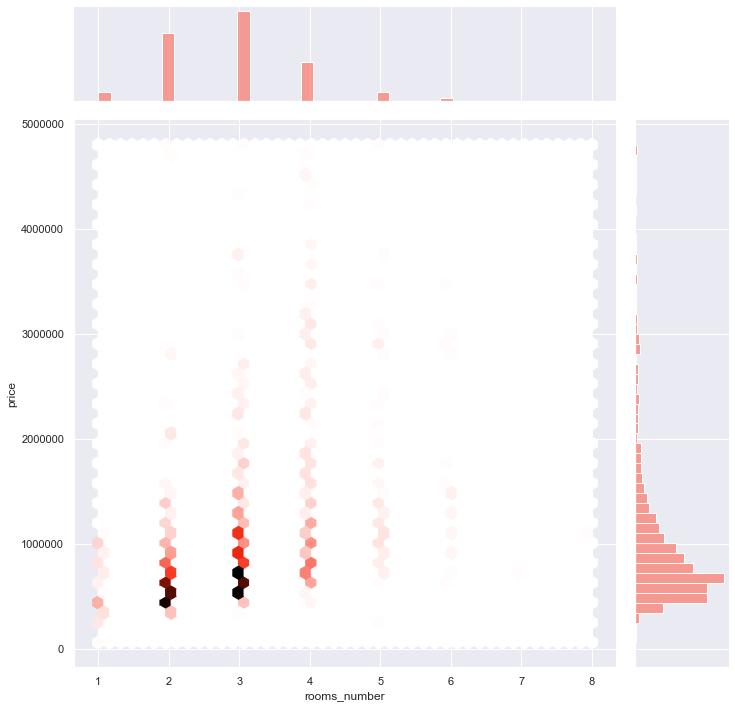

In [39]:
sns.jointplot(data=data, x="rooms_number", y="price", kind="hex", color='#fa8072', height = 10)

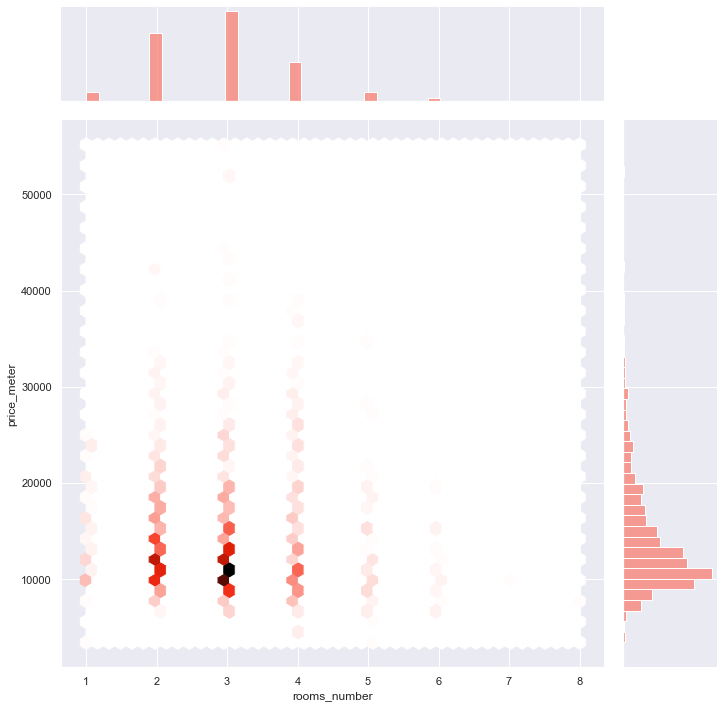

In [40]:
sns.jointplot(data=data, x="rooms_number", y="price_meter", kind="hex", color='#fa8072', height = 10)

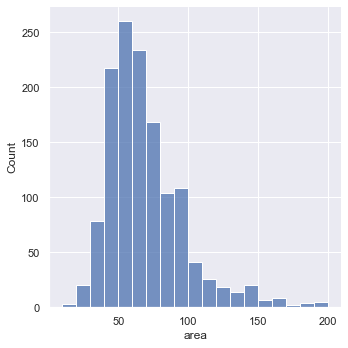

In [41]:
sns.displot(data, x="area", bins=list(range(10,int(max(data['area'])) + 10, 10)))

In [50]:
print(  list(range(int(min(data['price'])), int(max(data['price'])), 50000))   )

[60000, 110000, 160000, 210000, 260000, 310000, 360000, 410000, 460000, 510000, 560000, 610000, 660000, 710000, 760000, 810000, 860000, 910000, 960000, 1010000, 1060000, 1110000, 1160000, 1210000, 1260000, 1310000, 1360000, 1410000, 1460000, 1510000, 1560000, 1610000, 1660000, 1710000, 1760000, 1810000, 1860000, 1910000, 1960000, 2010000, 2060000, 2110000, 2160000, 2210000, 2260000, 2310000, 2360000, 2410000, 2460000, 2510000, 2560000, 2610000, 2660000, 2710000, 2760000, 2810000, 2860000, 2910000, 2960000, 3010000, 3060000, 3110000, 3160000, 3210000, 3260000, 3310000, 3360000, 3410000, 3460000, 3510000, 3560000, 3610000, 3660000, 3710000, 3760000, 3810000, 3860000, 3910000, 3960000, 4010000, 4060000, 4110000, 4160000, 4210000, 4260000, 4310000, 4360000, 4410000, 4460000, 4510000, 4560000, 4610000, 4660000, 4710000, 4760000]


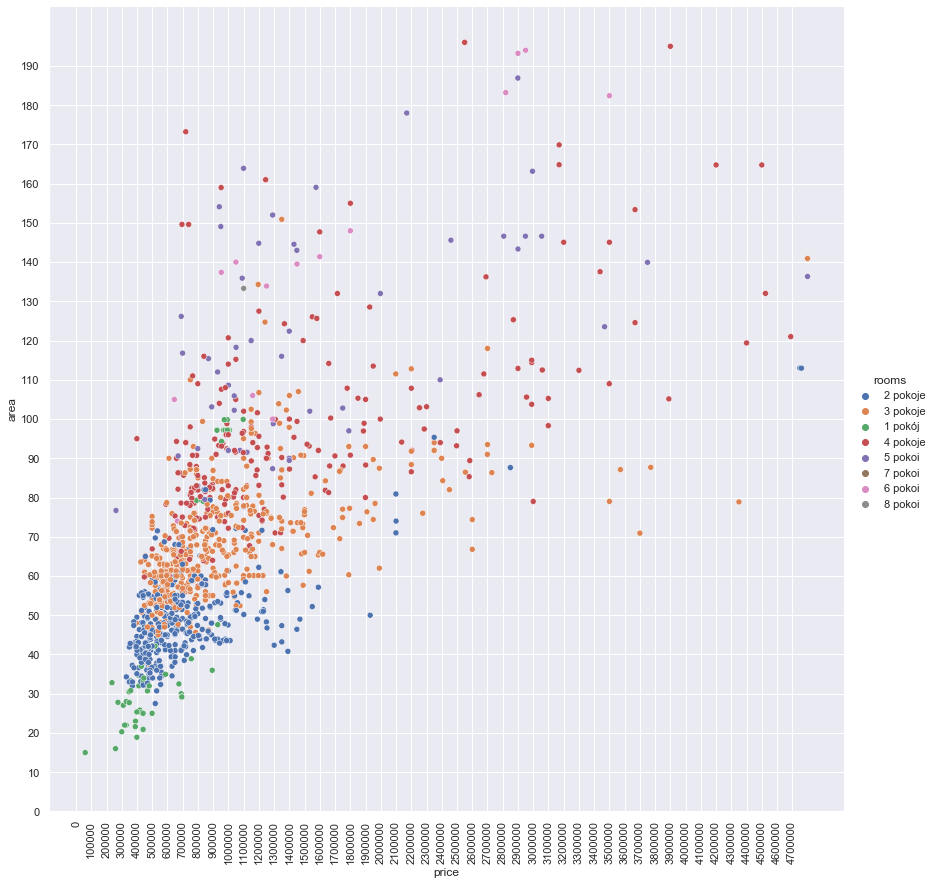

In [61]:
sns.relplot(data=data, x="price", y="area", hue="rooms", height=12)
plt.xticks(list(range(0, int(max(data['price'])), 100000)), rotation='vertical')
plt.yticks(list(range(0, int(max(data['area'])), 10)))
# plt.xticks(rotation=90)
plt.show()